# Predictive Coding Modeling

Faxin Zhou (Feb. 23, 2025)

This notebook aims for building the continous and sparse updating predictive coding (PC) models (referred to as the continuous model and sparse model hereafter).

**Continuous model**

Specifically, for the continous models, we construct the below diferential equations to simulate the neural oscillators between word and sentence levels:
$$\frac{d Z_w(t)}{dt} = w_0 \cdot x_w(t + dt) + w_1 \cdot (Z_s(t) - Z_w(t))$$
$$x_s(t + dt) = Z_s(t) - Z_w(t + dt)$$
$$\frac{d Z_s(t)}{dt} = s_0 \cdot x_s(t + dt) + s_1 \cdot (Prior(t) - Z_s(t))$$

Briefly, $Z_w(t)$ and $Z_s(t)$ represent the neural signals at word and sentence levels (see paper for more details). Furthermore, I would like to dig deeper about the meaning of different parameters. To this end, I will first simplify the above equations:
$$\frac{d Z_w(t)}{dt} = - w_1 \cdot Z_w(t) + w_1 \cdot Z_s(t) +  w_0 \cdot x_w(t + dt)$$
$$\frac{d Z_s(t)}{dt} = (s_0 - s_1) \cdot Z_s(t) - s_0 \cdot Z_w(t + dt)$$
given that the $prior(t)$ is set as 0. 

In this way, we could speculate that the $w_0$ controls to what extent the prediction error at the word level (i.e., $x_w$) affects this neural oscillator. The parameter $w_1$ and $(s_0 - s_1)$ controls the decay rate of the neural signals at word and sentence levels ($Z_w$ and $Z_s$). Given the fact that the neural signal is always decay when input is off and avoid the "signal explosion", so we need to make sure that:
$$w_1 > 0; s_1 > s_0$$
which is important for obtaining a biological plausible signals. Notably, the absolute values of $w_1$ and $s_0 - s_1$ determine the decay rate, where a larger value means a faster decay. Therefore, by tuning up these value, one may expect to see the frequency changes of the neural signals.

In addition, $w_1$ and $s_0$ control how word ($Z_w$) and sentence ($Z_s$) levels are affected interactively.

**Sparse model**

[TO BE EDITED]

In [1]:
## load package
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
## define some functions
class fMRI_model:
    ''' 
    This class is used to simulate the fMRI signal with PC models.
    '''
    def __init__(self, dt, nscan, mode = 'continous', boundary = []):
        self.dt = dt
        self.nscan = nscan  # num of scans
        self.sample_num = len(np.arange(0, nscan, dt))
        self.mode = mode
        self.boundary = boundary
        self.delay_list = self.sparse_delay(np.array(boundary) / dt) if boundary else []
            
    def sparse_delay(self, boundary):
        delay_list = []
        for b in range(self.sample_num):
            if b in boundary or b < boundary[0]:
                delay_list.append(0)
            else:
                delay_list.append(-1 + delay_list[b - 1])
        return np.array(delay_list)
    
    def neural_model(self, params, PE_word):
        # unpack params
        w_0, w_1, s_0, s_1 = params[0], params[1], params[2], params[3]
        # set initial state as 0
        dt = self.dt
        sample_num = self.sample_num
        delay_list = self.delay_list
        # set initial value as zero
        PE_sent = np.zeros(sample_num)
        Pred_word = np.zeros(sample_num)
        Pred_sent = np.zeros(sample_num)
        prior = np.zeros(sample_num)  # set prior as zero (Alamia, 2019)
        if self.mode == 'continous':
            # start!
            for t in range(sample_num - 1):
                Pred_word[t + 1] = Pred_word[t] + dt * (w_0 * PE_word[t + 1] + w_1 * (Pred_sent[t] - Pred_word[t]))
                PE_sent[t + 1] = Pred_sent[t] - Pred_word[t + 1]
                Pred_sent[t + 1] = Pred_sent[t] + dt * (s_0 * PE_sent[t + 1] + s_1 * (prior[t] - Pred_sent[t]))  

        elif self.mode == 'sparse':
            for t in range(sample_num - 1):
                Pred_word[t + 1] = Pred_word[t] + dt * (w_0 * PE_word[t + 1] + w_1 * (Pred_sent[max(0, t + delay_list[t])] - Pred_word[t]))
                PE_sent[t + 1] = Pred_sent[max(0, t + delay_list[t])] - Pred_word[max(0, t + 1 + delay_list[t])]
                Pred_sent[t + 1] = Pred_sent[t] + dt * (s_0 * PE_sent[t + 1] + s_1 * (prior[t] - Pred_sent[t]))  
        else: 
            raise TypeError("Please specify the model type!")
        return Pred_word, Pred_sent  # PE_sent

    def BOLD_model(self, x_word):
        # set parameters
        dt = self.dt
        sample_num = self.sample_num
        alpha = 0.32  # the stiffness of the blood vessel
        gamma = 0.25 # 0.41  # the time constant controlling the blood flow feedback
        E_0 = 0.34 # the resting oxygen extraction fraction E0
        V_0  = 4  # resting venous volume (%)
        kappa = 0.65  # from friston, 2000
        tau = 0.98  # from friston, 2000
        # 3T (Heinzle, 2016, Appendix A)
        B_0 = 3  # main magnetic field strength is 3T
        TE = 0.03 # TE is 30ms
        epsilon = 0.47; epsilon = np.exp(epsilon)  # the ratio between intra- and extra-vascular MR signal
        theta_0 = 28.265 * B_0  # the freq. offset at the outer surface of magnetized vessels
        r_0 = 110  # the intravascular relaxation rate
        k_1 = 4.3 * theta_0 * E_0 * TE
        k_2 = epsilon * r_0 * E_0 * TE
        k_3 = 1 - epsilon
        # set initial state as 0; 
        # The logs of states f, v and q are taken in order to enforce positivity constraints.
        s = np.zeros(sample_num + 1)  # vasodilatory signal
        f = np.zeros(sample_num + 1)  # blood flow  ln(f)
        v = np.zeros(sample_num + 1) # blood volume  ln(v)
        q = np.zeros(sample_num + 1) # deoxygenated hemoglobin (deoxyHb)  ln(q)
        y = np.zeros(sample_num + 1) # BOLD signal
        tau = np.exp(tau)
        f = np.exp(f); v = np.exp(v); q = np.exp(q)
        ## Start!
        for t in range(sample_num):
            # outflow
            f_out = v[t] ** (1 / alpha)
            # oxygen extraction
            oxy_extraction = (1 - (1 - E_0) ** (1 / f[t])) / E_0
            # implement differential state equation
            s[t + 1] = s[t] + dt * (x_word[t] - kappa * s[t] - gamma * (f[t] - 1))
            f[t + 1] = np.log(f[t]) + dt * (s[t] / f[t])
            v[t + 1] = np.log(v[t]) + dt * ((f[t] - f_out) / (v[t] * tau))
            q[t + 1] = np.log(q[t]) + dt * ((f[t] * oxy_extraction - f_out * q[t] / v[t]) / (q[t] * tau))
            f[t + 1] = np.exp(f[t + 1]); v[t + 1] = np.exp(v[t + 1]); q[t + 1] = np.exp(q[t + 1])
            y[t + 1] = V_0 * (k_1 * (1 - q[t + 1]) + k_2 * (1 - q[t + 1] / v[t + 1]) + k_3 * (1 - v[t + 1]))  # BOLD signal
        f = np.log(f); v = np.log(v); q = np.log(q)
        s = np.delete(s, 0); f = np.delete(f, 0); v = np.delete(v, 0); q = np.delete(q, 0); y = np.delete(y, 0)
        return y

    def generate_signal(self, params, PE_word):
        [w_tmp, s_tmp] = self.neural_model(params, PE_word)
        # rescale neural signal to small value, ensuring successful BOLD transformation
        w_tmp = (((w_tmp - np.min(w_tmp)) / (np.max(w_tmp) - np.min(w_tmp))) - 0.5) / 100
        s_tmp = (((s_tmp - np.min(s_tmp)) / (np.max(s_tmp) - np.min(s_tmp))) - 0.5) / 100
        w_tmp = self.BOLD_model(w_tmp)
        s_tmp = self.BOLD_model(s_tmp)
        # rescale BOLD signal to a range of 4
        w_tmp = (((w_tmp - np.min(w_tmp)) / (np.max(w_tmp) - np.min(w_tmp))) - 0.5) * 4
        s_tmp = (((s_tmp - np.min(s_tmp)) / (np.max(s_tmp) - np.min(s_tmp))) - 0.5) * 4
        return w_tmp, s_tmp
    
    def caculate_J(self, data_w, data_s, PE_word, params):
        s = data_w.shape[0]
        m = data_w.shape[1]
        try:
            [w_tmp, s_tmp] = self.generate_signal(params, PE_word)
            w_J, s_J = 0, 0
            for i in range(s):
                w_J += np.sum((w_tmp - data_w[i, :]) ** 2) / (2 * m)
                s_J += np.sum((s_tmp - data_s[i, :]) ** 2) / (2 * m)
            J = (w_J + s_J) / 2
        except:
            J = np.nan
            print('NUMERICAL ERROR MEET')
        return J / s
    
    def gradient_descent(self, data_w, data_s, PE_word, params, alpha, threshold):
        # unpack params
        w0, w1, s0, s1 = params[0], params[1], params[2], params[3]
        # initialize variables
        dw0, dw1, ds0, ds1 = 1e-6, 1e-6, 1e-6, 1e-6
        dJ = np.inf
        new_J = np.inf
        count = 0
        while dJ > threshold:
            count += 1
            old_J = new_J
            new_J = self.caculate_J(data_w, data_s, PE_word, params)
            if np.isnan(new_J) or count > 500:
                break
            dJdw0 = (self.caculate_J(data_w, data_s, PE_word, [w0 + dw0, w1, s0, s1]) - new_J) / dw0
            dJdw1 = (self.caculate_J(data_w, data_s, PE_word, [w0, w1 + dw1, s0, s1]) - new_J) / dw1
            dJds0 = (self.caculate_J(data_w, data_s, PE_word, [w0, w1, s0 + ds0, s1]) - new_J) / ds0
            dJds1 = (self.caculate_J(data_w, data_s, PE_word, [w0, w1, s0, s1 + ds1]) - new_J) / ds1
            tmp_w0 = w0 - alpha * dJdw0
            tmp_w1 = w1 - alpha * dJdw1
            tmp_s0 = s0 - alpha * dJds0
            tmp_s1 = s1 - alpha * dJds1
            params = [tmp_w0, tmp_w1, tmp_s0, tmp_s1]
            dJ = np.abs(new_J - old_J)
            # print('w0 is {}, w1 is {}, s0 is {}, s1 is {}; J is {}.'.format(w0, w1, s0, s1, new_J))
        return params, new_J
    

def fMRI_rescale(D):
    scale = (np.max(D, axis = 1) - np.min(D, axis = 1)).reshape(-1, 1)
    scale = 4 / np.max(np.hstack((scale, np.ones_like(scale) * 4)), axis = 1).reshape(-1, 1)
    return D * scale

def delay_resample(delay_list):
    # resample delay list to dt = 1 (originally dt = 2)
    delay_list = delay_list * 2
    tmp = [delay_list[round(i / 2)] if i % 2 == 0 else 1 for i in range(len(delay_list) * 2)]
    resampled_delay_list = []
    for i in range(len(tmp)):
        if tmp[i] != 1:
            resampled_delay_list.append(tmp[i])
        else:
            if i != len(tmp) - 1:
                if tmp[i + 1] == 0:
                    resampled_delay_list.append(tmp[i - 1] - 1)
                else:
                    resampled_delay_list.append((tmp[i + 1] + tmp[i - 1]) / 2)
            else:
                resampled_delay_list.append(tmp[i - 1] - 1)
    return np.int32(np.array(resampled_delay_list))


### Part 1: data simulation

First, let's make sure the hemodynamic and BOLD model is working.

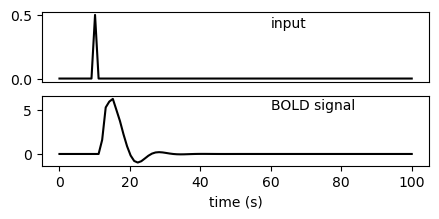

In [3]:
## Simulate an input signal
dt, nscan = 1, 100
I = np.zeros((int(nscan / dt), 1)); I[int(10 / dt)] = 0.5

## Instantiate the model
M = fMRI_model(dt = dt, 
               nscan = nscan)

## Generate BOLD signal
y = M.BOLD_model(I)

## visualization
fig = plt.figure(figsize = (5, 2))
ax1 = plt.subplot(2, 1, 1)
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, I, c = 'k')
plt.text(60, 0.4, 'input')
plt.xticks([])

ax2 = plt.subplot(2, 1, 2)
ax2 = plt.plot(np.linspace(0, nscan, nscan) / dt, y, c = 'k')
plt.text(60, 5, 'BOLD signal')
plt.xlabel('time (s)')

plt.show()

Then, let's simulate the fMRI data with PC models.

**Continous Model**

In [4]:
## define a function for visualization
def my_plot(dt, nscan, Nero_word, Nero_sent, BOLD_word, BOLD_sent):
    fig = plt.figure(figsize = (10, 3))
    ax1 = plt.subplot(2, 2, 1)
    ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, Nero_word, c = 'k')
    plt.title('Neuro_word')
    plt.xticks([])

    ax2 = plt.subplot(2, 2, 2)
    ax2 = plt.plot(np.linspace(0, nscan, nscan) / dt, Nero_sent, c = 'k')
    plt.title('Neuro_sent')
    plt.xticks([])

    ax3 = plt.subplot(2, 2, 3)
    ax3 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_word, c = 'k')
    plt.title('BOLD_word')
    plt.xlabel('time (s)')

    ax4 = plt.subplot(2, 2, 4)
    ax4 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_sent, c = 'k')
    plt.title('BOLD_sent')
    plt.xlabel('time (s)')

    plt.tight_layout()
    plt.show()

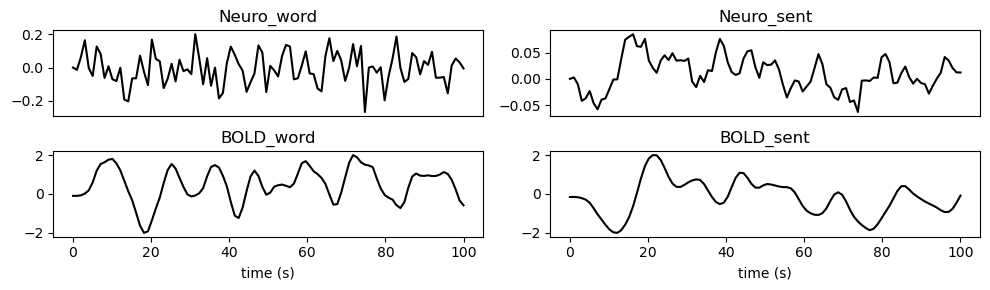

In [5]:
## Initialize variables and params (continous model)
np.random.seed(42)

dt, nscan = 1, 100
# PE_word = np.zeros((int(nscan / dt), 1))  # no word-level PE (input) in this case
PE_word = np.random.normal(size = int(nscan / dt))  # random word-level PE (input)
params = [0.1, .7, .2, .3]  # w_0, w_1, s_0, s_1
# params = [1, .1, -.2, 1.5]


## Instantiate the model (continous model)
M = fMRI_model(dt = dt, 
               nscan = nscan,
               mode = 'continous')

## signal generation
Nero_word, Nero_sent = M.neural_model(params, PE_word)
BOLD_word, BOLD_sent = M.generate_signal(params, PE_word)

## visualization
my_plot(dt, nscan, Nero_word, Nero_sent, BOLD_word, BOLD_sent)


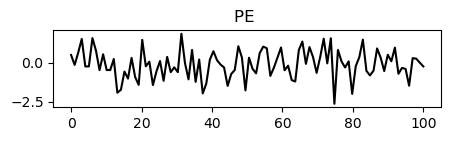

In [6]:
## visualize PE
fig = plt.figure(figsize = (5, 1))
plt.plot(np.linspace(0, nscan, nscan) / dt, PE_word, c = 'k')
plt.title('PE ')

plt.show()

**Sparse model**

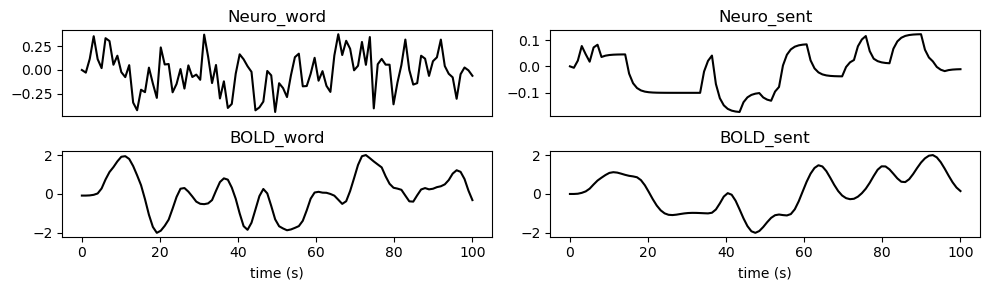

In [8]:
## Initialize variables and params (sparse model)
np.random.seed(42)

dt, nscan = 1, 100
boundary = [8, 14, 33, 36, 43, 48, 51, 53, 60, 69, 72, 75, 77, 81, 89, 92, 95]  # sentence boundary (in scan) 
PE_word = np.random.normal(size = int(nscan / dt))  # random word-level PE (input)
params = [.2, .7, -.2, .5]
# params = [.2, .7, .2, .3]

## Instantiate the model (continous model)
M = fMRI_model(dt = dt, 
               nscan = nscan,
               mode = 'sparse',
               boundary = boundary)

## signal generation
Nero_word, Nero_sent = M.neural_model(params, PE_word)
BOLD_word, BOLD_sent = M.generate_signal(params, PE_word)

## visualization
my_plot(dt, nscan, Nero_word, Nero_sent, BOLD_word, BOLD_sent)

We can also visualize the boundary timestamps:

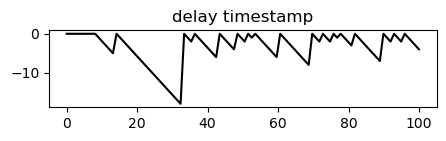

In [211]:
fig = plt.figure(figsize = (5, 1))
plt.plot(np.linspace(0, nscan, nscan) / dt, np.array(M.delay_list), c = 'k')
plt.title('delay timestamp')

plt.show()

### Part 2: parameters estimation

Now let's apply the gradient descent method to evaluate the parameters of the simulated data.

**Continous model**

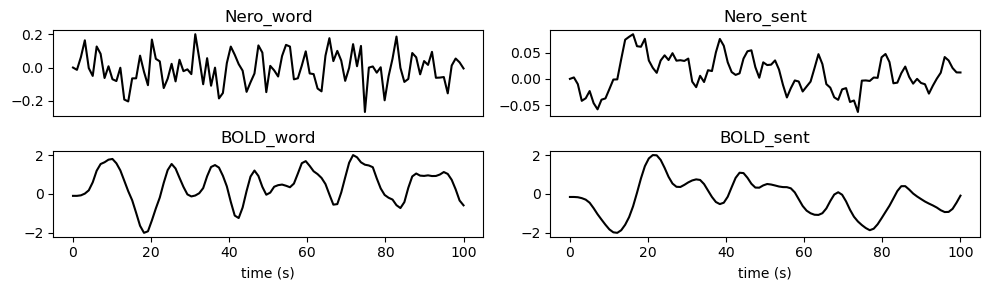

In [5]:
## Initialize variables and params (continous model)
np.random.seed(42)
dt, nscan = 1, 100
PE_word = np.random.normal(size = int(nscan / dt))  # random word-level PE (input)
params = [0.1, .7, .2, .3]  # w_0, w_1, s_0, s_1

## Instantiate the model (continous model)
M = fMRI_model(dt = dt, 
               nscan = nscan,
               mode = 'continous')

## signal generation
Nero_word, Nero_sent = M.neural_model(params, PE_word)
BOLD_word, BOLD_sent = M.generate_signal(params, PE_word)

## visualization
my_plot(dt, nscan, Nero_word, Nero_sent, BOLD_word, BOLD_sent)

Given the observation signals (i.e., fMRI BOLD signals), we can start the parameter evaluation process:

In [9]:
#%% choose the optimal initial values
n = 100  # number of repetition
alpha = 1e-5  # learning rate
threshold = 1e-4  # for convergence
J_ls = []; 
M_eval = fMRI_model(dt = dt, 
                    nscan = nscan,
                    mode = 'continous')

params_init = np.zeros((n, 4))  
params_eval = np.zeros((n, 4))  
for i in range(n):
    p = np.random.uniform(-1, 1, (4))  # p[0] is w0, p[1] is w1, p[2] is s0, p[3] is s1
    p[0] = abs(p[0])  # w0 > 0
    p[3] = p[2] + p[3]  # s1 > s0
    params_init[i, :] = p.reshape(1, -1)
    p_eval, J = M_eval.gradient_descent(BOLD_word.reshape(1, -1), BOLD_sent.reshape(1, -1), PE_word, p, alpha, threshold)
    J_ls.append(J)
    params_eval[i, :] = p_eval
    i += 1
    print('ONGOING TRIALS {}'.format(i + 1)) if (i + 1) % 10 == 0 else None

ONGOING TRIALS 10
ONGOING TRIALS 20
ONGOING TRIALS 30
ONGOING TRIALS 40
ONGOING TRIALS 50
ONGOING TRIALS 60
ONGOING TRIALS 70
ONGOING TRIALS 80
ONGOING TRIALS 90
ONGOING TRIALS 100


Then, we could visualize J as a function of trials to find the best one:

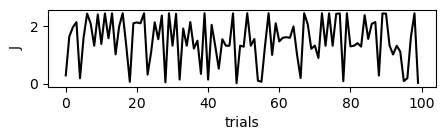

In [20]:
ax = plt.figure(figsize = (5, 1))
plt.plot(J_ls, 'k')
plt.ylabel('J')
plt.xlabel('trials')
plt.show()

To compare the estimated signals and the original signals:

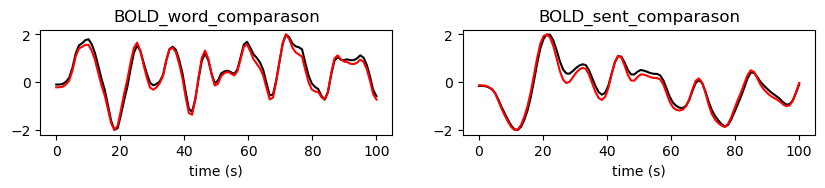

In [22]:
BOLD_word_sim, BOLD_sent_sim = M.generate_signal(params_eval[np.argmin(J_ls), :], PE_word)

fig = plt.figure(figsize = (10, 3))
ax1 = plt.subplot(2, 2, 1)
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_word, c = 'k')
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_word_sim, c = 'r')
plt.title('BOLD_word_comparason')
plt.xlabel('time (s)')

ax1 = plt.subplot(2, 2, 2)
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_sent, c = 'k')
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_sent_sim, c = 'r')
plt.title('BOLD_sent_comparason')
plt.xlabel('time (s)')

plt.show()

**Sparse model**

Similarly, for the sparse model:

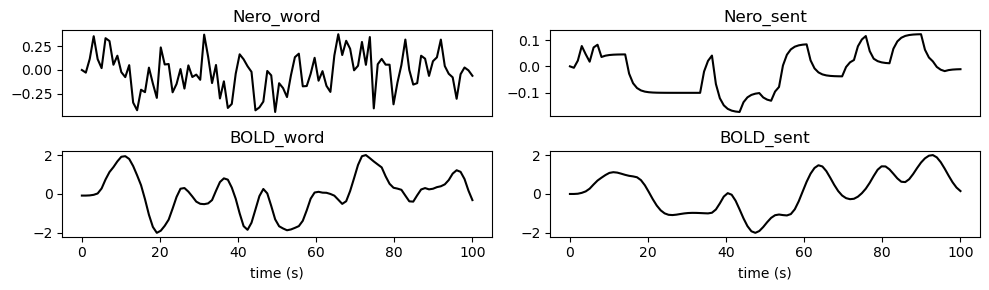

In [23]:
## Initialize variables and params (sparse model)
np.random.seed(42)

dt, nscan = 1, 100
boundary = [8, 14, 33, 36, 43, 48, 51, 53, 60, 69, 72, 75, 77, 81, 89, 92, 95]  # sentence boundary (in scan) 
PE_word = np.random.normal(size = int(nscan / dt))  # random word-level PE (input)
params = [.2, .7, -.2, .5]
# params = [.2, .7, .2, .3]

## Instantiate the model (continous model)
M = fMRI_model(dt = dt, 
               nscan = nscan,
               mode = 'sparse',
               boundary = boundary)

## signal generation
Nero_word, Nero_sent = M.neural_model(params, PE_word)
BOLD_word, BOLD_sent = M.generate_signal(params, PE_word)

## visualization
my_plot(dt, nscan, Nero_word, Nero_sent, BOLD_word, BOLD_sent)

In [24]:
#%% choose the optimal initial values
n = 100  # number of repetition
alpha = 1e-5  # learning rate
threshold = 1e-4  # for convergence
J_ls = []; 
M_eval = fMRI_model(dt = dt, 
                    nscan = nscan,
                    mode = 'sparse',
                    boundary = boundary)

params_init = np.zeros((n, 4))  
params_eval = np.zeros((n, 4))  
for i in range(n):
    p = np.random.uniform(-1, 1, (4))  # p[0] is w0, p[1] is w1, p[2] is s0, p[3] is s1
    p[0] = abs(p[0])  # w0 > 0
    p[3] = p[2] + p[3]  # s1 > s0
    params_init[i, :] = p.reshape(1, -1)
    p_eval, J = M_eval.gradient_descent(BOLD_word.reshape(1, -1), BOLD_sent.reshape(1, -1), PE_word, p, alpha, threshold)
    J_ls.append(J)
    params_eval[i, :] = p_eval
    i += 1
    print('ONGOING TRIALS {}'.format(i + 1)) if (i + 1) % 10 == 0 else None

ONGOING TRIALS 10
ONGOING TRIALS 20
ONGOING TRIALS 30
ONGOING TRIALS 40
ONGOING TRIALS 50
ONGOING TRIALS 60
ONGOING TRIALS 70
ONGOING TRIALS 80
ONGOING TRIALS 90
ONGOING TRIALS 100


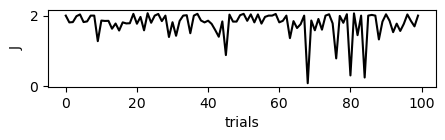

In [25]:
ax = plt.figure(figsize = (5, 1))
plt.plot(J_ls, 'k')
plt.ylabel('J')
plt.xlabel('trials')
plt.show()

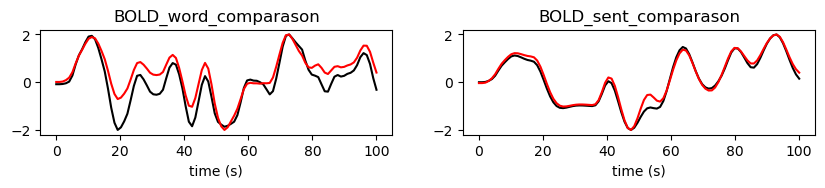

In [26]:
BOLD_word_sim, BOLD_sent_sim = M.generate_signal(params_eval[np.argmin(J_ls), :], PE_word)

fig = plt.figure(figsize = (10, 3))
ax1 = plt.subplot(2, 2, 1)
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_word, c = 'k')
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_word_sim, c = 'r')
plt.title('BOLD_word_comparason')
plt.xlabel('time (s)')

ax1 = plt.subplot(2, 2, 2)
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_sent, c = 'k')
ax1 = plt.plot(np.linspace(0, nscan, nscan) / dt, BOLD_sent_sim, c = 'r')
plt.title('BOLD_sent_comparason')
plt.xlabel('time (s)')

plt.show()